<h1>Industrial Accidents Predictions</h1>


<p> Today we are going to build a Machine learning model to predicts accidents in the industrial sector.

For this project we are going to use : <br />
    -Python languague <br />
    -Pandas, Numpy, Sklearn, MatplotLib and Seaborn frameworks. <br />
    -Jupyter notebooks for this scenenario <br />
</p>


<p> The first thing is setting the necessary imports </p>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns



<h4> Disclaimer </h4>
<p> Since I know that I will encounter different problems during the process, I don't like doing all the imports at first, I just <br />
write the ones that I am 100% sure I will need. I think that a lot of time is wasted when you try to realise at the very first moment which are all the <br /> tools that you are going to use, I personally preffer to prepare some general tools that I always use and then grab the neccesary ones. </p>


<p> Now let's see which is the content of our dataset and if there is some missing information </p>

In [ ]:
class DataExtractor():
    def datapreparer(self, route):
        self.dataset = pd.read_csv(route)
        dataset_columns = self.dataset.columns
        print(self.dataset.columns)

    def data_checking(self):
        print(self.dataset.head())
        mising_col =[col for col in self.dataset.columns if self.dataset[col].isnull().sum() > 0]
        if len(mising_col) > 0:
            print("There is missing information")
        else:
            print("There is no missing data")

    def data_replacing(self):
        self.dataset.replace(['Country_01', 'Country_02', 'Country_03'], ['Spain', 'Germany', 'USA'], inplace = True)
        self.dataset.replace(['Local_01', 'Local_02', 'Local_03'], ['Madrid', 'Berlin', 'New York'], inplace = True)

    def data_visualization_sns(self):
        sector_accidents = self.dataset['Industry Sector'].value_counts()
        genre_accidents = self.dataset['Genre'].value_counts()
        employee_third = self.dataset['Employee ou Terceiro'].value_counts()
        accident_level = self.dataset['Accident Level'].value_counts()
        country_accidents = self.dataset['Countries'].value_counts()


        fig,axes = plt.subplots(1,5,figsize = (20,5))

        axes[0].pie(sector_accidents, labels = sector_accidents.index, autopct = '%1.1f%%', colors=['gold', 'skyblue', 'lightgreen'], startangle=90)
        axes[0].set_title('Accidents in each sector')

        axes[1].pie(genre_accidents, labels =genre_accidents.index, autopct = '%1.1f%%', colors=['red', 'blue', ], startangle=90)
        axes[1].set_title('Accidents in each genre')

        axes[2].pie(employee_third, labels = employee_third.index, autopct = '%1.1f%%', colors=['green', 'purple'], startangle=90)
        axes[2].set_title('Employee or third party')

        axes[3].pie(accident_level, labels = accident_level.index, autopct = '%1.1f%%', colors=['orange', 'brown', 'black', 'yellow', 'pink'], startangle=90)
        axes[3].set_title('Accident level')

        axes[4].pie(country_accidents, labels = country_accidents.index, autopct = '%1.1f%%', colors=['orange', 'brown', 'black'], startangle=90)
        axes[4].set_title('Accidents in each country')

        plt.show()



    def model_charging(self):
    	models ={
    		'random_forest':{
    			'model':RandomForestClassifier(),
    			'parameters':{
    				'n_estimators': [50, 100, 200],
    				'max_depth': [None, 10, 20],
    				'min_samples_split': [2,5,10]
    			}
    		},

    		'decision_tree':{
    			'model':DecisionTreeClassifier(criterion = 'gini'),
    			'parameters':{
    				'max_depth': [None,10,20],
    				'min_samples_split': [2,5,10]
    			}
    		},
    		'svm':{
    			'model':SVC(),
    			'parameters':{
    				'C': [0.1,1,10],
    				'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    				'gamma': ['scale', 'auto']
    			}
    		}
        }

    	return models

    def grid_preprocessor(self, models):

        self.oneh = OneHotEncoder(sparse_output = False)
        self.label = LabelEncoder()
        kFold = StratifiedKFold(n_splits = 5)

        features = self.dataset.drop('Industry Sector', axis = 'columns')
        encoded_features = self.oneh.fit_transform(features)
        print(f"Encoded features size {encoded_features.shape}")

        encoded_dataframe = pd.DataFrame(encoded_features)
        self.encoded_columns = encoded_dataframe.columns

        labels = self.dataset['Industry Sector']
        labels = pd.DataFrame(labels)
        encoded_labels = self.label.fit_transform(labels)



        scores =[]

        for model_name,model_params in models.items():
            print(f"Using model {model_name}")
            gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = 10, return_train_score = False)
            gs.fit(encoded_features, encoded_labels)
            scores.append({'model':model_name, 'best_parameters':gs.best_params_,'score':	gs.best_score_
            })

        x_train, x_test, y_train, y_test = train_test_split(encoded_features, encoded_labels, test_size = 0.2, random_state = 0)

        predictions = gs.predict(x_test)

        return pd.DataFrame(scores, columns =['model', 'best_parameters', 'score'])

    def model_selection2(self,data, models):
        #COMMENED LINES BELONGS TO THE CHANCE OF BEING A REGRESSION PROBLEM

        model = data.loc[data['score'].idxmax(), 'model']
        self.parameters = data.loc[data['score'].idxmax(), 'best_parameters']
        self.oneh = OneHotEncoder(sparse_output = False)
        self.label = LabelEncoder()

        selected_model = models[model]
        self.selected_model = selected_model['model']
        self.selected_model.set_params(**self.parameters)
        self.model_plot = self.selected_model


        features = self.dataset.drop('Industry Sector', axis = 'columns')

        self.encoded_features = self.oneh.fit_transform(features)
        features_dataframe = pd.DataFrame(self.encoded_features)
        self.encoded_columns = features_dataframe.columns

        labels = self.dataset['Industry Sector']
        self.encoded_labels = self.label.fit_transform(labels)

        x_train, x_test, y_train, y_test = train_test_split(self.encoded_features, self.encoded_labels, test_size = 0.2, random_state = 0)

        self.selected_model.fit(x_train, y_train)
        train_prediction = self.selected_model.predict(x_train)
        self.train_error = accuracy_score(y_train, train_prediction)


        predictions = self.selected_model.predict(x_test)
        self.test_error = accuracy_score(y_test, predictions)

        print(f"Training time output {predictions.shape}")
        print(f"Error in training time {self.test_error * 100:.2f}%")

        return predictions



    def model_selection(self):
        self.oneh = OneHotEncoder(sparse_output = False)
        self.label = LabelEncoder()

        self.selected_model = RandomForestClassifier(max_depth = 10, n_estimators = 100)
        features = self.dataset.drop('Industry Sector', axis = 'columns')
        encoded_features = self.oneh.fit_transform(features)
        features_dataframe = pd.DataFrame(encoded_features)
        self.encoded_columns = features_dataframe.columns

        labels = self.dataset['Industry Sector']
        encoded_labels = self.label.fit_transform(labels)

        x_train, x_test, y_train, y_test = train_test_split(encoded_features, encoded_labels, test_size = 0.2, random_state = 0)

        self.selected_model.fit(x_train, y_train)
        predictions = self.selected_model.predict(x_test)
        error = mean_squared_error(y_test, predictions)
        print(f"Training time output {predictions.shape}")
        print(f"Error in training time {error * 100:.2f}%")

    def new_predictions(self, new_data):
    	new_data_encoded = pd.get_dummies(new_data)
    	predictions = self.selected_model.predict(new_data_encoded)
    	print(f"Normal prediction shape {predictions.shape}")
    	return predictions

    def get_encoding_info(self, prediction):
    	output_decoded = self.label.inverse_transform(prediction)
    	print(f"Categories: \n {output_decoded}")

    def check_learning_curve(self):

        train_sizes, train_scores, test_scores = learning_curve(self.model_plot, self.encoded_features, self.encoded_labels, cv = 5, scoring="accuracy",
                                                                train_sizes = np.linspace(0.1,1.0,10), n_jobs = -1)

        train_mean = train_scores.mean(axis = 1)
        test_mean = test_scores.mean(axis = 1)
        train_std = train_scores.std(axis = 1)
        test_std = test_scores.std(axis = 1)

        plt.figure(figsize=(8, 6))

        plt.plot(train_sizes, test_mean, label="Validation Score", color="r", marker="o")

        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="g")
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="r")
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.title("Learning Curve: Training vs Validation")
        plt.legend()
        plt.show()



In [ ]:
route = "./archive/IHMStefanini_industrial_safety_and_health_database.csv"
new_data_extractor = DataExtractor()
new_data_extractor.datapreparer(route)


<h2> Value information</h2>
<p> The columns can sometimes provide information about what is in them, but many times watching their name can not be enough, <br /> because they are not so descriptive or another reason, so let's print some of their values but not all of them </p>.
<p> On the other side we are iterating over every column of our dataset finding any possibility of having a null value, our model won't perform correctly if some values are missing, if it was the case, we could fix that missing value with 0 and the corresponding column's mean</p>

In [ ]:
new_data_extractor.data_checking()

<h2> Dataset general overview </h2>
<p> So watching the values we can have a general overview of this dataset content <br />
This dataset contains information about accidents in the industrial sector, with the following details:</br>
&nbsp -Date when it happened. </br>
&nbsp -Country where the accident took place. </br>
&nbsp -Local number where it occurs. </br>
&nbsp -In which sector did it happened. </br>
&nbsp -Accident Level (we can guess it is the consequences level, how harsh they were). </br>
&nbsp -Potential Accident Level (we can guess it's also about the consequences level, how severe they could have been). </br>
&nbsp -Genre of the person who suffered the accident. </br>
&nbsp -Was it an Employee our Third party member. </br>
&nbsp -The department, type of job that the accident belonged. </br>
</p>

<h4> Disclaimer </h4>
<p> When some information is not clear enough, maybe the columns names are not so descriptive <br />
and the values doesn't help at speaking about the information, we should ask our clients to be 100% sure about <br />
what the data is saying about the accidents in this case. <br /> <br />
For example "Local" column, the name is not very descriptive, we could guess It's talking about the location where the industry is, <br />
but It can be literally whatever the client decided it to be, and the values just indicates that there are more than one. <br />
So this is a good case to show to our clients, the interest that we have making a really good work.

<h2> Data replacing </h2>
After speaking with our clients and clarify some doubts about the existing information, for the sake of clarity we are going to replace the existing data values for something more detailed.

In this case we will replace [Country_01, Country_02, Country_03] for [Spain, Germany and USA]. <br />


<h2> Data visualization </h2>

Now we will use what Matplotlib and Seaborn are capable of, we are going to plot some information to realise about our data distribution, how many accidents each industry has, the difference between men and women accidents, the accident level of each one...



In [ ]:
new_data_extractor.data_visualization_sns()

With this visualizations we are able to get some relevant information from our dataset, mining industry is the hardest one in terms of accidents, male suffer much more accidents and employees seems safer than third party workers

<h2> What are we capable of doing using with Machine learning algorithms? </h2>

<p/> One of the thing that I personally love the most about Machine learning, is that we are able to predict what is <strong> most likely to </strong>strong> happen in the future <br/>
thank to that information we have in the dataset. <br /> <br />
Imagine that you are Head Officer of this industry and you want to know what is <strong>most likely going to </strong>strong> happen in a certain date, with some conditions, in the Mining industry so you can actually take some safety measures in order to avoid accidents. This is the moment to apply Machine learning in your business</p>

So what we are first going to do, is <strong> predicting </strong> under certain conditions which is the Industry that is <strong> most likely to </strong> have some accidents

<h3> This is a screenshoot, if you want to copy some code, the whole class is at start</h3>


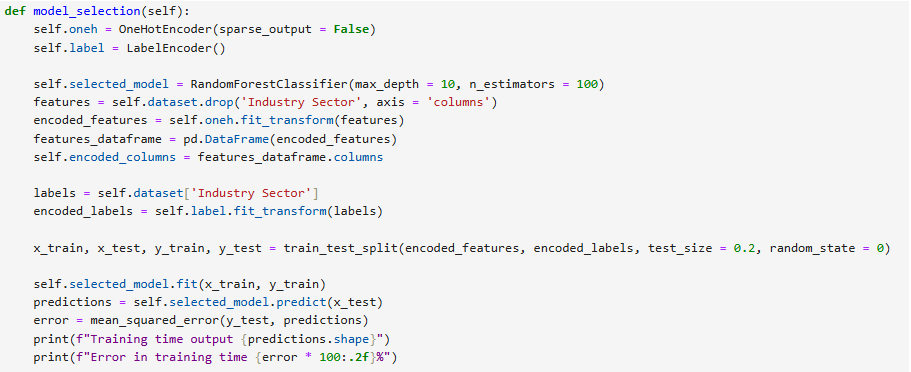

<h2> What are we doing in this function? </h2>
<p> This dataset contains categorical information, this means we are not talking about numbers, just places, dates, industries, so we need something </br>
to turn this data into numbers that our algorithm can work with to get new predictions. This is the moment to use encoders, this tool is going to transform our data into numbers, this way our algorithm is going to be able to handle categorical data. </br> </p>

<h3> OneHotEncoder vs LabelEncoder </h3>
<p> OneHotEncoder builds Binary matrix (one-hot vectors) with our data so each columns is a matrix with the possible values of this column represented, but we all know that "A picture is worth a thousand words", so I will let this magnificient image speak for me. </p>



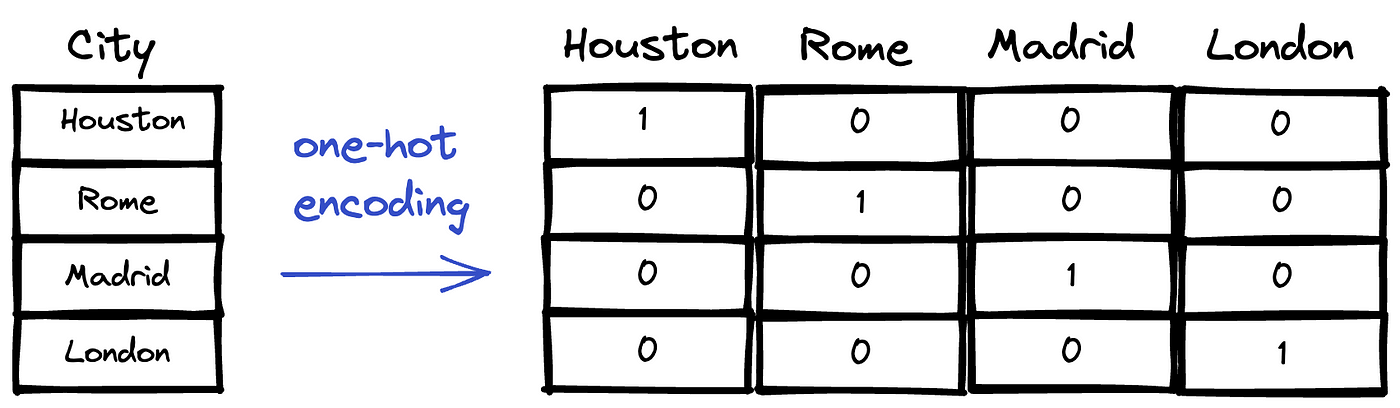


The column city has 4 posible values, so OneHot build a matrix with the possible values, the values marked with 1 are the one selected for the specific row




On the other hand LabelEncoder is simply turning a Not a Number value(NaN) into a number, <strong> but this can be problematic  Why? </strong>

<p>Imagine the column Genre, where the value Male is turned into 0 and the value Female is turned into 1, with a LabelEncoding the algorithm understand that 1 is greater(better) than 0 and it will asign a higher value to Female. <strong> That's a big problem at making predictions </strong><p>

The algorithm selected is a RandomForestClassifier, if we want to validate what classifier algorithm to use, we could do a GridSearch to compare different classification algorithms to use and it's parameters, then get the one with the higher accuracy. <br />
We will use the <strong>RandomForestClassifier</strong> implementation from <strong> sklearn.ensemble</strong>

<p> The label we are trying to predict is the Industry Sector where the accidents would take place so, we have to: <br />
    &nbsp -Drop that columns from our dataset in training time. <br/>
    &nbsp -After removing that column, we encode the rest of the features using OneHot. <br />
    &nbsp -Save the columns configuration created after passing the dataset through OneHot, this process is neccesary for the future at inference time. </p>

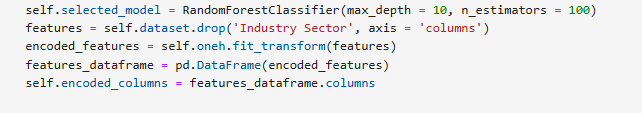

After that we create a new dataframe, for the labels that we dropped before, and encode them using the LabelEncoder.

<p>
The next steps are: <br />
&nbsp -Dividing our dataset into training and testing data. <br/>
&nbsp -Fit the model to our training features and labels. <br/>
&nbsp -Make predictions with out testing features.<br/>
&nbsp -Compare predictions with testing labels.<br/>
</p>
<h4>Disclaimer</h4>
This dataset it's pretty short and that would probably drop the model performance, it will probably overfit that short quantity of training data, but the idea is to show the process, in a real case we would need more traning data and make some better hyperparameter tunning to get the best performance

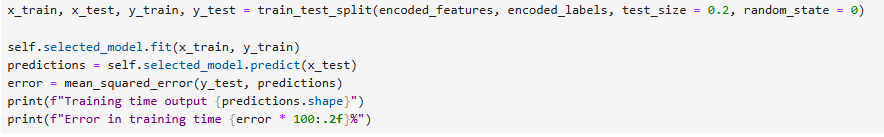

In [ ]:
new_data_extractor.model_selection()


<h2> Now what? </h2>
Our model is already fitted, the next step is to prepare for inference time, so we can make predictions for the future using our already trained model and the following function

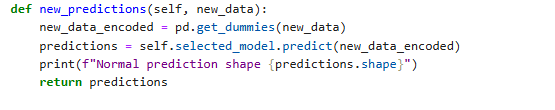
<h3> What is this function doing?</h3>
<p>In this function we are receiving new data, for example: <br/>
    &nbsp -A date. <br/>
    &nbsp -One of the countries. <br/>
    &nbsp -A concrete local. <br/>
    &nbsp -Accident level. <br/>
    &nbsp -Potential accident level.
    &nbsp -A genre. <br/>
    &nbsp -One of the type of workers. <br/>
    &nbsp -A "department". <br/>

Creating a new dataframe for this data, and reindexing it with the encoded columns, Do you remember that moment before when we saved a column configuration? Now we need it for encoding new data into the same format so our algorithm can work with it.<br />
After that we call self.selected_model.predict() on new data so we can make the prediction.<br ><br />
Now in the predictions variable we have the result, the industry sector in which the accident is most likely to take place. However it is represented by a number, specifically an encoded industry sector, so we need to decode it back to it's original name."
</p>


In [ ]:
new_data = pd.DataFrame([[
    '2016-01-01 00:00:00', 'Country_01', 'Local_01', 'I', 'IV', 'Male', 'Third Party', 'Pressed'
]], columns=['Data', 'Countries', 'Local',  'Accident Level',
             'Potential Accident Level', 'Genre', 'Employee ou Terceiro', 'Risco Critico'])


new_data = new_data.reindex(columns = new_data_extractor.encoded_columns, fill_value = 0)
prediction = new_data_extractor.new_predictions(new_data)

<h2> Decoding the prediction </h2>

![image.png](attachment:c49df1fa-cbd6-48eb-8160-a5383b9a72fc.png)

<p> This code receives a OneHotEncoded prediction and decodes it back using the inverse_transform function </p>

In [ ]:
new_data_extractor.get_encoding_info(prediction)


<h2> Adding more complexity and variety. GridSearch </h2>

<p> A very interesting feature that sklearn comes with, is the GridSearch method, imagine that you can't decide between using three 3 different algorithms, in this case we want to decide between using a DecisionTreeClassifier, RandomForesClassifier and Support Vector Machines.
We can use a GridSearch to compare between these algorithms and also to compare between a set of parameters for each algorithm.</p>

In the following image, we are building a dictionary with models and different parameters, now we will iterate over it and select the best performing model.

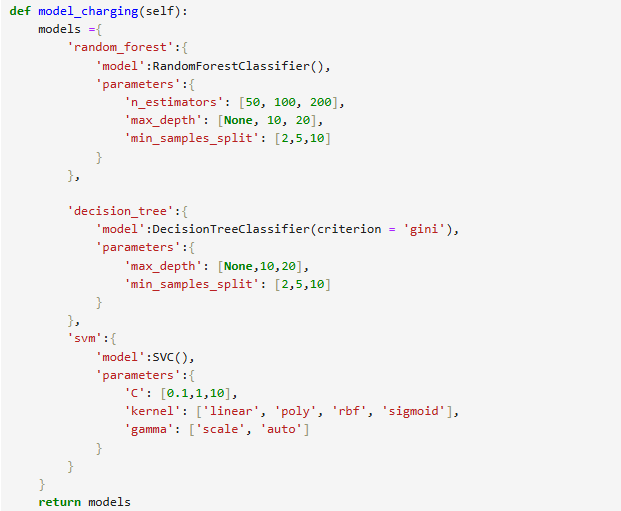


<h4> Now we are going to iterate over the models and it's parameters </h4>

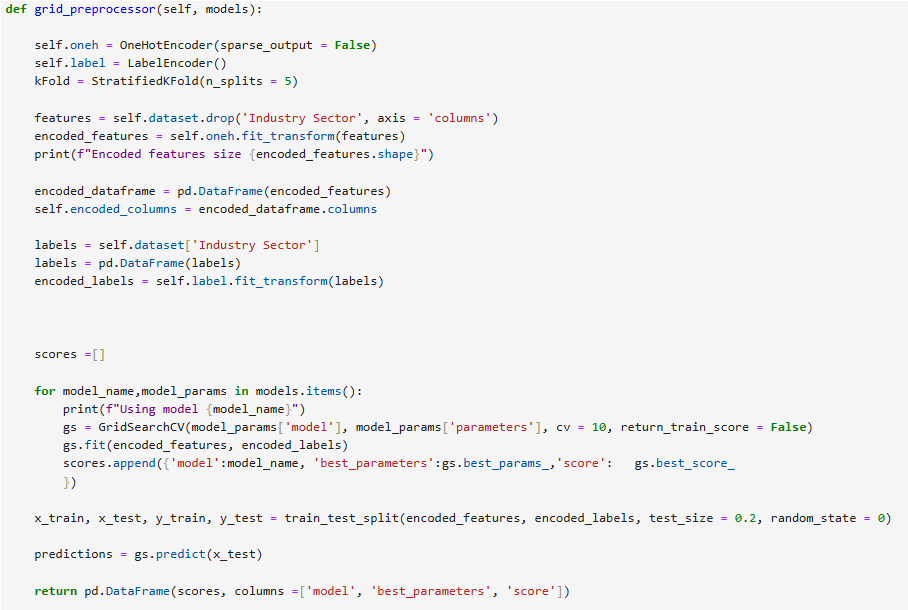


In [ ]:
models = new_data_extractor.model_charging()

In [ ]:
data = new_data_extractor.grid_preprocessor(models)
print(data)

Now we are going to call a new model_selection function, it's doing basically the same thing, but at the start we are choosing the models and it's parameters using the results from before

In [ ]:
new_data_extractor.model_selection2(data, models)

new_data = pd.DataFrame([[
    '2016-01-01 00:00:00', 'Country_01', 'Local_01', 'I', 'IV', 'Male', 'Third Party', 'Pressed'
]], columns=['Data', 'Countries', 'Local',  'Accident Level',
             'Potential Accident Level', 'Genre', 'Employee ou Terceiro', 'Risco Critico'])


new_data = new_data.reindex(columns = new_data_extractor.encoded_columns, fill_value = 0)
prediction = new_data_extractor.new_predictions(new_data)
new_data_extractor.get_encoding_info(prediction)

<h2> Learning curve </h2>

We can use a learning curve to control how our model's accuracy grows as it learns behaviours and patterns from our data

In [ ]:
print(new_data_extractor.model_plot)
new_data_extractor.check_learning_curve()


<h1> API creation to access our model </h1>

Now we will start creating our API using FastAPI to access our model for real-time inference, this will we allow us to make inference on our model and get predictions for new data.

Let's create a api_prepare file and start.

<h3> Disclaimer</h3>
I will give the APICode by screenshoots, to check how the API works you can the application on production that is already deployed on : "APP LINK"



First we create the structure of the json Item that our endpoint will recieve

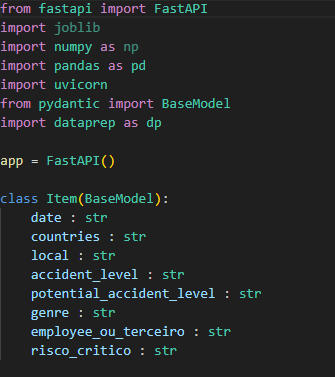
<p>
Now we are going to prepare the endpoint to receive our data, In this endpoint we will: <br />
&nbsp -Build a Pandas DataFrame with the data received. <br />
&nbsp -Reindex the colums of the DataFrame so we have the proper columns for inference. <br />
&nbsp -Call new_predictions functions to make the inference and print the result for the new data. <br />
</p>

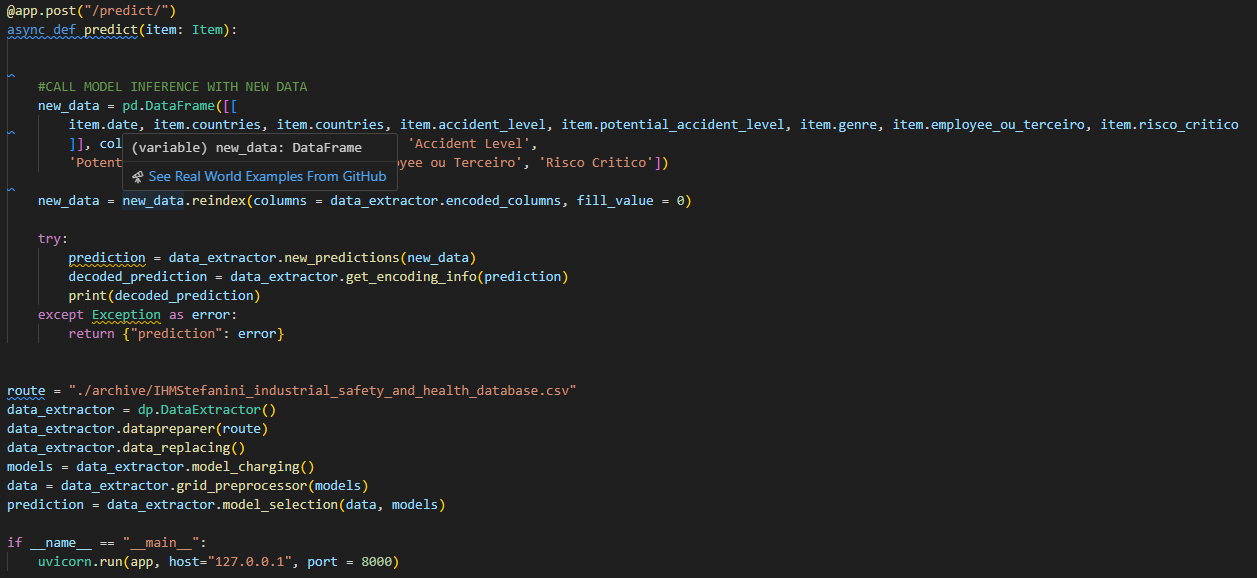

<h3> Launch the endpoint </h3>
The next code is the neccesary to launch our endpoint from a terminal, but in this case we will use a docker container

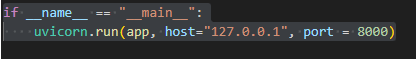





<h2> Container preparation </h2>

-Create a dockerfile  <br />
-Use the slim version of the one we are using. <br />
-Set the working directory inside our docker. <br />
-Copy our requirements.txt file to include the dependencies for the frameworks we are using. <br />
-Install the requirements. <br />
-Expose the port that we want to use. <br />

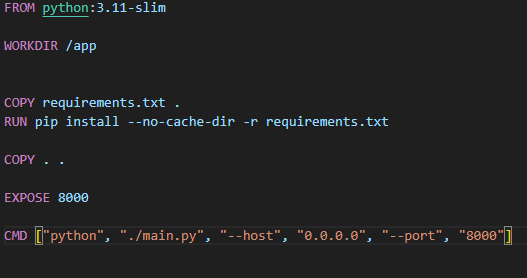